# Hybrid Recommender System with DeepCTR-Torch

**Project context:** Hybrid recommendation modeling using DeepCTR-Torch  
**Goal:** Build and compare multiple DeepCTR-based configurations using content and contextual features, then evaluate with standard ranking/prediction metrics.

## 🔍 Overview

This notebook implements a hybrid recommender system using **DeepCTR-Torch** on **MovieLens-100K**.  
The workflow covers feature preparation, context enrichment, model training, and metric-based comparison across multiple model variants.

## Dataset

The MovieLens-100K dataset is used to train and evaluate the models.

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [3]:
!pip install wget
!pip install zipfile36
!pip3 install implicit --upgrade
!python -m wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!pip install deepctr-torch
!pip install tensorflow

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=01e29b4f0c9d42a8fc5d42e5e18b05fd0548f9d182a2c0f5194c15ba1dfa525b
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 82.9 MB/s eta 0:00:00

Saved under ml-100k.zip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import zipfile
with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import implicit
import scipy.sparse as sparse
import time
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from deepctr_torch.inputs import SparseFeat, VarLenSparseFeat, get_feature_names,DenseFeat
from deepctr_torch.models import DeepFM

In [6]:
def split(x):
    key_ans = x.split('|')
    for key in key_ans:
        if key not in key2index:
            key2index[key] = len(key2index) + 1
    return list(map(lambda x: key2index[x], key_ans))

In [7]:
dir_train = 'ml-100k'
columns = ['itemid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [8]:
df = pd.read_csv(f'{dir_train}/u.data',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

In [9]:
df_items = pd.read_csv(f'{dir_train}/u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None,
                        encoding='latin-1')

In [10]:
columns_user = ['userid', 'age', 'gender', 'occupation', 'zip_code']

In [11]:
df_users = pd.read_csv(f'{dir_train}/u.user',
                        sep='|',
                        index_col=0,
                        names = columns_user,
                        header=None,
                        encoding='latin-1')
df_users = df_users.reset_index()
df_items = df_items.reset_index()

In [12]:
df_total = pd.merge(df, df_users, on='userid')
df_total = pd.merge(df_total, df_items, on='itemid')

In [13]:
def combine_genres(row):
    genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
    return '|'.join([col for col, val in row.items() if val == 1 and col in genres])

In [14]:
df_total['genres'] = df_total.apply(combine_genres, axis=1)

In [15]:
genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
df_total = df_total.drop(genres, axis=1)

In [16]:
df_total.sort_values(by='timestamp').head(10)

,userid,itemid,rating,timestamp,age,gender,occupation,zip_code,title,release_date,video_release_date,IMDb_URL,unknown,genres
214,259,255,4,874724710,21,M,student,48823,My Best Friend's Wedding (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,Comedy|Romance
83965,259,286,4,874724727,21,M,student,48823,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,0,Drama|Romance|War
43027,259,298,4,874724754,21,M,student,48823,Face/Off (1997),27-Jun-1997,NaN,http://us.imdb.com/M/title-exact?Face/Off+(1997),0,Action|Sci-Fi|Thriller
21396,259,185,4,874724781,21,M,student,48823,Psycho (1960),01-Jan-1960,NaN,http://us.imdb.com/M/title-exact?Psycho%20(1960),0,Horror|Romance|Thriller
82655,259,173,4,874724843,21,M,student,48823,"Princess Bride, The (1987)",01-Jan-1987,NaN,http://us.imdb.com/M/title-exact?Princess%20Br...,0,Action|Adventure|Comedy|Romance
10891,259,108,4,874724882,21,M,student,48823,Kids in the Hall: Brain Candy (1996),12-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Kids%20in%20t...,0,Comedy
1766,259,772,4,874724882,21,M,student,48823,Kids (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Kids%20(1995),0,Drama
26399,259,288,3,874724905,21,M,student,48823,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),0,Horror|Thriller
85297,259,928,4,874724937,21,M,student,48823,"Craft, The (1996)",26-Apr-1996,NaN,"http://us.imdb.com/M/title-exact?Craft,%20The%...",0,Drama|Horror
159,259,117,4,874724988,21,M,student,48823,"Rock, The (1996)",07-Jun-1996,NaN,"http://us.imdb.com/M/title-exact?Rock,%20The%2...",0,Action|Adventure|Thriller


# 🧭 Workflow

1. Load and prepare MovieLens-100K  
2. Analyze content features  
3. Engineer contextual features  
4. Train multiple DeepCTR model configurations  
5. Compare performance and validate a simple hypothesis from the feature exploration

In [53]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   userid              100000 non-null  int64  
 1   itemid              100000 non-null  int64  
 2   rating              100000 non-null  int64  
 3   timestamp           100000 non-null  int64  
 4   age                 100000 non-null  int64  
 5   gender              100000 non-null  int64  
 6   occupation          100000 non-null  int64  
 7   zip_code            100000 non-null  object 
 8   title               100000 non-null  object 
 9   release_date        99991 non-null   object 
 10  video_release_date  0 non-null       float64
 11  IMDb_URL            99987 non-null   object 
 12  unknown             100000 non-null  int64  
 13  genres              100000 non-null  int64  
 14  diadesemana         100000 non-null  int64  
dtypes: float64(1), int64(10), object(4)

In [18]:
df_total.head()

,userid,itemid,rating,timestamp,age,gender,occupation,zip_code,title,release_date,video_release_date,IMDb_URL,unknown,genres
0,196,242,3,881250949,49,M,writer,55105,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,Comedy
1,186,302,3,891717742,39,F,executive,00000,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,Crime|Film-Noir|Mystery|Thriller
2,22,377,1,878887116,25,M,writer,40206,Heavyweights (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Heavyweights%...,0,Children|Comedy
3,244,51,2,880606923,28,M,technician,80525,Legends of the Fall (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Legends%20of%...,0,Drama|Romance|War|Western
4,166,346,1,886397596,47,M,educator,55113,Jackie Brown (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,Crime|Drama


In [19]:
train, test = train_test_split(df_total, test_size=0.2, random_state=42)

## Content feature analysis

This section reviews core user/item attributes available in MovieLens-100K and visualizes a subset of features used later for modeling (user demographics and item genres).

This section explores and visualizes key *content* attributes used by the recommender (e.g., user attributes, item genres).

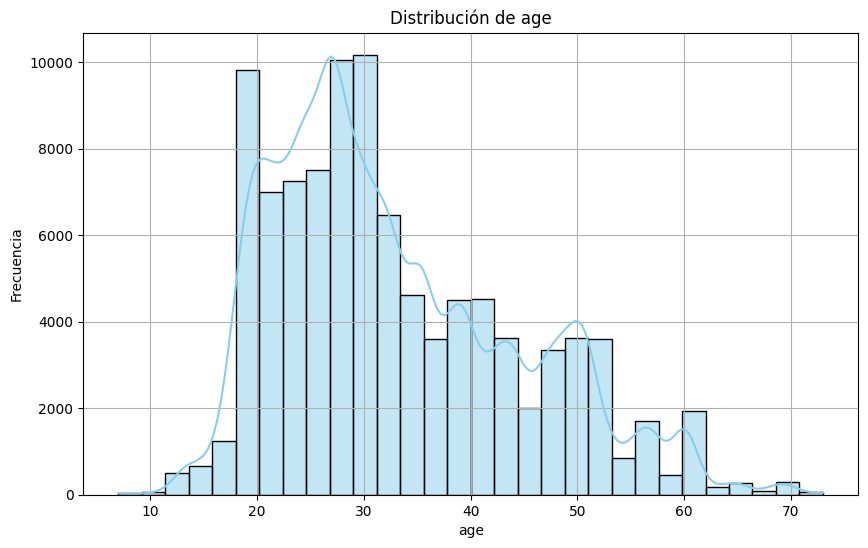

Continuous variable type
The mean de age es: 32.97
The standard deviation de age es: 11.56


In [20]:
columna = 'age'  # Change this if you want a different variable
df_plot = df_total.dropna(subset=[columna])
plt.figure(figsize=(10, 6))
sns.histplot(df_plot[columna], kde=True, bins=30, color='skyblue', edgecolor='black')  # Histogram + KDE curve
plt.title(f'Distribution of {columna}')
plt.xlabel(columna)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
media = df_plot[columna].mean()
desviacion = df_plot[columna].std()

print("Continuous variable type")
print(f'The mean of {columna} is: {media:.2f}')
print(f'The standard deviation of {columna} is: {desviacion:.2f}')

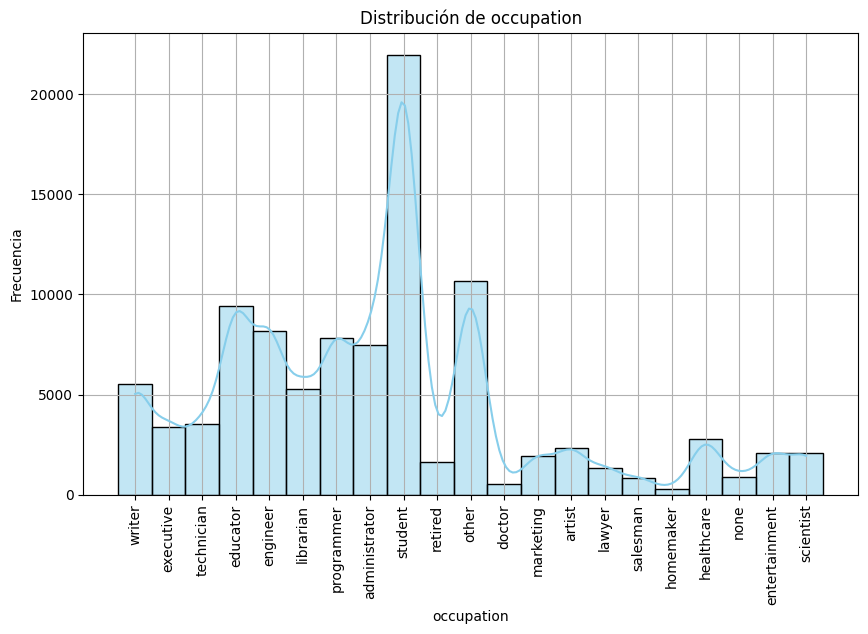

Tipo de variable discreta
Most common value in 'occupation' es 'student' con 21957 apariciones.
Least common value in 'occupation' es 'homemaker' con 299 apariciones.


In [21]:
columna = 'occupation'  # Change this if you want a different variable
df_plot = df_total.dropna(subset=[columna])
plt.figure(figsize=(10, 6))
sns.histplot(df_plot[columna], kde=True, bins=30, color='skyblue', edgecolor='black')  # Histogram + KDE curve
plt.title(f'Distribution of {columna}')
plt.xlabel(columna)
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()
conteo = df_total[columna].value_counts()
valor_max = conteo.idxmax()
cantidad_max = conteo.max()
valor_min = conteo.idxmin()
cantidad_min = conteo.min()

print("Tipo de variable discreta")
print(f"Most common value in '{columna}' es '{valor_max}' con {cantidad_max} apariciones.")
print(f"Least common value in '{columna}' es '{valor_min}' con {cantidad_min} apariciones.")

<ipython-input-22-78ba3916b0c6>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_generos.index, y=df_generos['count'], palette='viridis')


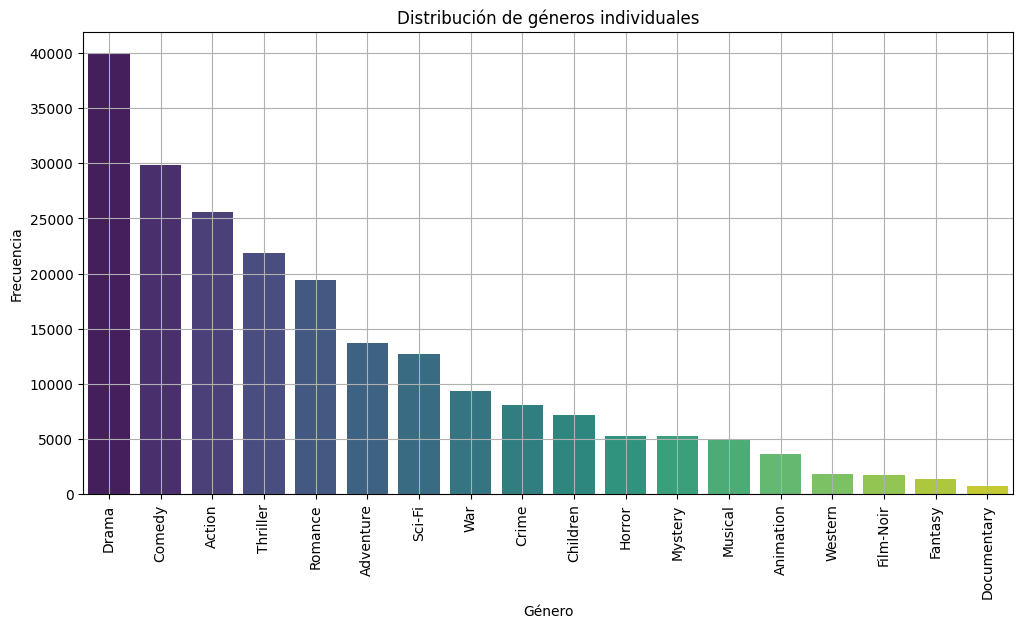

Discrete variable type
Most popular genre is 'Drama' con 39895 apariciones.
Least popular genre is 'Documentary' con 758 apariciones.


In [22]:
from collections import Counter

generos_lista = df_total['genres'].dropna().str.split('|').sum()
generos_lista = [g for g in generos_lista if g != '']
conteo_generos = Counter(generos_lista)
df_generos = pd.DataFrame.from_dict(conteo_generos, orient='index', columns=['count'])
df_generos = df_generos.sort_values(by='count', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=df_generos.index, y=df_generos['count'], palette='viridis')
plt.title('Distribution of individual genres')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

valor_max = df_generos['count'].idxmax()
cantidad_max = df_generos['count'].max()
valor_min = df_generos['count'].idxmin()
cantidad_min = df_generos['count'].min()

print("Discrete variable type")
print(f"Most popular genre is '{valor_max}' con {cantidad_max} apariciones.")
print(f"Least popular genre is '{valor_min}' con {cantidad_min} apariciones.")


## Context feature engineering

Here, the raw event timestamp is transformed into a lightweight contextual signal (weekday vs weekend), which is then encoded for use in the models.

In [23]:
def day_type_func(dia):
    if dia in [5,6]:
        return "weekend"
    else:
        return "weekday"
df_total['day_type'] = pd.to_datetime(df_total['timestamp'], unit='s').dt.dayofweek.apply(day_type_func)
df_total['day_type'] = df_total['day_type'].astype('category').cat.codes

In [52]:
df_total.head(1)

,userid,itemid,rating,timestamp,age,gender,occupation,zip_code,title,release_date,video_release_date,IMDb_URL,unknown,genres,diadesemana
0,196,242,3,881250949,49,1,20,55105,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,120,0


**Hypothesis:** Viewing patterns differ between weekdays and weekends for certain genre groups, suggesting that a simple day-type context feature can improve recommendations.

## Model training

Three DeepCTR-Torch configurations are trained:
- **Model 1:** user–item interaction features only  
- **Model 2:** interaction features + selected content features  
- **Model 3:** Model 2 + contextual day-type signal  

Training logs are tracked to compare learning dynamics and final performance.

In [31]:
categorical_columns = ['gender', 'occupation', 'genres', 'day_type']
label_encoders = {}
for col in categorical_columns:
    encoder = LabelEncoder()
    df_total[col] = encoder.fit_transform(df_total[col].astype(str))
    label_encoders[col] = encoder


In [33]:
sparcol1 = [
    SparseFeat('userid', vocabulary_size=df_total['userid'].max() + 1, embedding_dim=8),
    SparseFeat('itemid', vocabulary_size=df_total['itemid'].max() + 1, embedding_dim=8),
]
dnncol1 = sparcol1
lincol1 = sparcol1
ftnames1 = get_feature_names(dnncol1 + lincol1)
sparcol2 = [
    SparseFeat('userid', vocabulary_size=df_total['userid'].max() + 1, embedding_dim=8),
    SparseFeat('itemid', vocabulary_size=df_total['itemid'].max() + 1, embedding_dim=8),
    SparseFeat('gender', vocabulary_size=df_total['gender'].max() + 1, embedding_dim=8),
    SparseFeat('occupation', vocabulary_size=df_total['occupation'].max() + 1, embedding_dim=8),
    SparseFeat('genres', vocabulary_size=df_total['genres'].max() + 1, embedding_dim=8),
    DenseFeat('age', 1)
]
dnncol2 = sparcol2
lincol2 = sparcol2
ftnames2 = get_feature_names(dnncol2 + lincol2)
sparcol3 = [
    SparseFeat('userid', vocabulary_size=df_total['userid'].max() + 1, embedding_dim=8),
    SparseFeat('itemid', vocabulary_size=df_total['itemid'].max() + 1, embedding_dim=8),
    SparseFeat('gender', vocabulary_size=df_total['gender'].max() + 1, embedding_dim=8),
    SparseFeat('occupation', vocabulary_size=df_total['occupation'].max() + 1, embedding_dim=8),
    SparseFeat('genres', vocabulary_size=df_total['genres'].max() + 1, embedding_dim=8),
    SparseFeat('day_type', vocabulary_size=df_total['day_type'].max() + 1, embedding_dim=8),
    DenseFeat('age', 1)
]
dnncol3 = sparcol3
lincol3 = sparcol3
ftnames3 = get_feature_names(dnncol3 + lincol3)


In [34]:
dnncols = [dnncol1, dnncol2, dnncol3]
lincols = [lincol1, lincol2, lincol3]
ftnamess = [ftnames1, ftnames2, ftnames3]


In [35]:
batch_sizes = [256, 128, 512]
epochs = [12, 15, 20]
embedding_dims = [8, 4, 16]

In [37]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import torch
from deepctr_torch.models import DeepFM
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
from sklearn.model_selection import train_test_split
import pandas as pd
train, test = train_test_split(df_total, test_size=0.2, random_state=42)
target = ['rating']
final_mse_results = []
for i in range(3):
    print(f'\nEntrenando Model {i+1}...\n')

    model = DeepFM(
        linear_feature_columns=lincols[i],
        dnn_feature_columns=dnncols[i],
        task='regression',
        device='cpu'
    )

    model.compile("adam", "mse", metrics=["mse"])

    trainmodel = {name: train[name] for name in ftnamess[i]}
    testmodel = {name: test[name] for name in ftnamess[i]}

    history = model.fit(
        trainmodel,
        train[target].values,
        batch_size=batch_sizes[i],
        epochs=epochs[i],
        verbose=2,
        validation_split=0.2
    )
    print(f'\nModelo {i+1} terminado.\n')
    final_val_mse = history.history['mse'][-1]
    final_mse_results.append(final_val_mse)
mse_df = pd.DataFrame({
    'Model': [f'Model {i+1}' for i in range(len(final_mse_results))],
    'MSE': final_mse_results
})
print(mse_df)


Entrenando Model 1...

cpu
Train on 64000 samples, validate on 16000 samples, 250 steps per epoch
Epoch 1/12
2s - loss:  2.2688 - mse:  2.2688 - val_mse:  0.9141
Epoch 2/12
4s - loss:  0.8837 - mse:  0.8837 - val_mse:  0.8927
Epoch 3/12
2s - loss:  0.8671 - mse:  0.8671 - val_mse:  0.8900
Epoch 4/12
2s - loss:  0.8608 - mse:  0.8608 - val_mse:  0.8936
Epoch 5/12
2s - loss:  0.8575 - mse:  0.8575 - val_mse:  0.8916
Epoch 6/12
2s - loss:  0.8552 - mse:  0.8552 - val_mse:  0.8913
Epoch 7/12
2s - loss:  0.8531 - mse:  0.8531 - val_mse:  0.8905
Epoch 8/12
2s - loss:  0.8516 - mse:  0.8516 - val_mse:  0.8917
Epoch 9/12
2s - loss:  0.8509 - mse:  0.8509 - val_mse:  0.8876
Epoch 10/12
3s - loss:  0.8500 - mse:  0.8500 - val_mse:  0.8894
Epoch 11/12
2s - loss:  0.8498 - mse:  0.8498 - val_mse:  0.8886
Epoch 12/12
2s - loss:  0.8472 - mse:  0.8472 - val_mse:  0.8935

Model 1 terminado.


Entrenando Model 2...

cpu
Train on 64000 samples, validate on 16000 samples, 500 steps per epoch
Epoch 1/15

In [42]:

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import torch
from deepctr_torch.models import DeepFM
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_total, test_size=0.2, random_state=42)
train['rating_binary'] = (train['rating'] > 3).astype(int)
test['rating_binary'] = (test['rating'] > 3).astype(int)
target = ['rating_binary']
batch_sizes = [256, 128, 512]
epochs = [12, 15, 20]
for i in range(3):
    print(f'\nEntrenando Model {i+1}...\n')

    model = DeepFM(
        linear_feature_columns=lincols[i],
        dnn_feature_columns=dnncols[i],
        task='binary',  # 🔥 Ahora model binario
        device='cpu'
    )

    model.compile("adam", "binary_crossentropy", metrics=["auc"])

    trainmodel = {name: train[name] for name in ftnamess[i]}
    testmodel = {name: test[name] for name in ftnamess[i]}

    model.fit(
        trainmodel,
        train[target].values,
        batch_size=batch_sizes[i],
        epochs=epochs[i],
        verbose=2,
        validation_split=0.2
    )

    print(f'\nModelo {i+1} terminado.\n')



Entrenando Model 1...

cpu
Train on 64000 samples, validate on 16000 samples, 250 steps per epoch
Epoch 1/12
4s - loss:  0.6287 - auc:  0.7307 - val_auc:  0.7685
Epoch 2/12
4s - loss:  0.5609 - auc:  0.7794 - val_auc:  0.7763
Epoch 3/12
3s - loss:  0.5519 - auc:  0.7876 - val_auc:  0.7771
Epoch 4/12
4s - loss:  0.5481 - auc:  0.7896 - val_auc:  0.7762
Epoch 5/12
3s - loss:  0.5458 - auc:  0.7914 - val_auc:  0.7762
Epoch 6/12
3s - loss:  0.5443 - auc:  0.7923 - val_auc:  0.7767
Epoch 7/12
3s - loss:  0.5432 - auc:  0.7932 - val_auc:  0.7760
Epoch 8/12
4s - loss:  0.5416 - auc:  0.7940 - val_auc:  0.7755
Epoch 9/12
3s - loss:  0.5409 - auc:  0.7939 - val_auc:  0.7768
Epoch 10/12
3s - loss:  0.5400 - auc:  0.7955 - val_auc:  0.7768
Epoch 11/12
3s - loss:  0.5370 - auc:  0.7968 - val_auc:  0.7781
Epoch 12/12
3s - loss:  0.5335 - auc:  0.7989 - val_auc:  0.7798

Model 1 terminado.


Entrenando Model 2...

cpu
Train on 64000 samples, validate on 16000 samples, 500 steps per epoch
Epoch 1/15

## Training configurations

- **Model 1:** interaction-only baseline (user–item)  
- **Model 2:** baseline + selected content features (user/item attributes)  
- **Model 3:** Model 2 + a contextual day-type feature (weekday vs weekend)

All models are trained for comparable epoch ranges while varying batch size to study convergence and generalization.

## Performance evaluation

Model quality is compared using MSE and AUC across epochs. The tables and charts below summarize the training curves and highlight the best-performing configuration.

The following tables and plots summarize the metrics collected during training and evaluation (MSE/AUC across epochs).

In [49]:
mse_modelo1 = [2.2688, 0.8837, 0.8671, 0.8608, 0.8575, 0.8552, 0.8531, 0.8516, 0.8509, 0.8500, 0.8498, 0.8472]
mse_modelo2 = [1.3683, 0.8914, 0.8808, 0.8752, 0.8700, 0.8700, 0.8675, 0.8648, 0.8651, 0.8632, 0.8593, 0.8586, 0.8589, 0.8545, 0.8545]
mse_modelo3 = [2.6108, 0.9274, 0.8697, 0.8595, 0.8550, 0.8511, 0.8506, 0.8497, 0.8493, 0.8487,
               0.8469, 0.8465, 0.8463, 0.8471, 0.8487, 0.8441, 0.8446, 0.8441, 0.8448, 0.8443]
data = []

# Model 1
for epoch, mse in enumerate(mse_modelo1, start=1):
    data.append({"Model": "Model 1", "Epoch": epoch, "MSE": mse})

# Model 2
for epoch, mse in enumerate(mse_modelo2, start=1):
    data.append({"Model": "Model 2", "Epoch": epoch, "MSE": mse})

# Model 3
for epoch, mse in enumerate(mse_modelo3, start=1):
    data.append({"Model": "Model 3", "Epoch": epoch, "MSE": mse})

# Convertir a DataFrame
mse_epochs_df = pd.DataFrame(data)

# Mostrar
print(mse_epochs_df)

      Model  Epoch     MSE
0   Model 1      1  2.2688
1   Model 1      2  0.8837
2   Model 1      3  0.8671
3   Model 1      4  0.8608
4   Model 1      5  0.8575
5   Model 1      6  0.8552
6   Model 1      7  0.8531
7   Model 1      8  0.8516
8   Model 1      9  0.8509
9   Model 1     10  0.8500
10  Model 1     11  0.8498
11  Model 1     12  0.8472
12  Model 2      1  1.3683
13  Model 2      2  0.8914
14  Model 2      3  0.8808
15  Model 2      4  0.8752
16  Model 2      5  0.8700
17  Model 2      6  0.8700
18  Model 2      7  0.8675
19  Model 2      8  0.8648
20  Model 2      9  0.8651
21  Model 2     10  0.8632
22  Model 2     11  0.8593
23  Model 2     12  0.8586
24  Model 2     13  0.8589
25  Model 2     14  0.8545
26  Model 2     15  0.8545
27  Model 3      1  2.6108
28  Model 3      2  0.9274
29  Model 3      3  0.8697
30  Model 3      4  0.8595
31  Model 3      5  0.8550
32  Model 3      6  0.8511
33  Model 3      7  0.8506
34  Model 3      8  0.8497
35  Model 3      9  0.8493
3

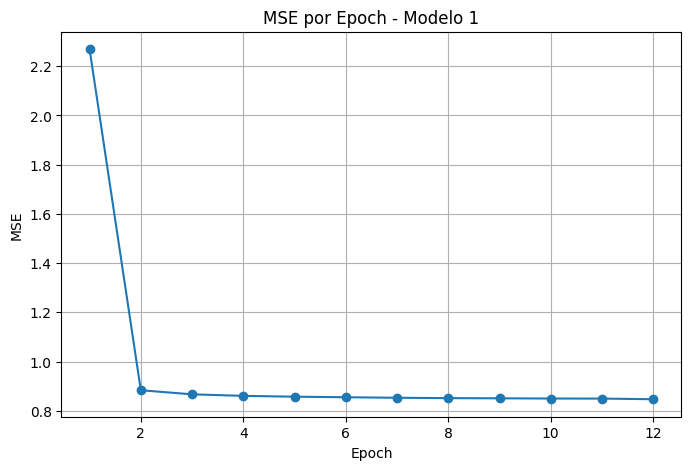

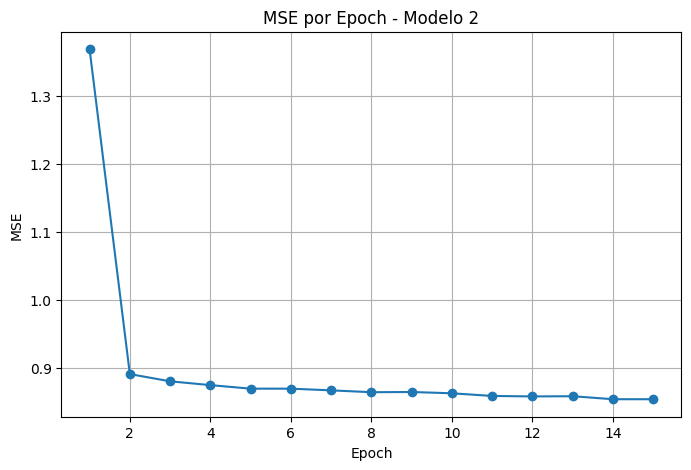

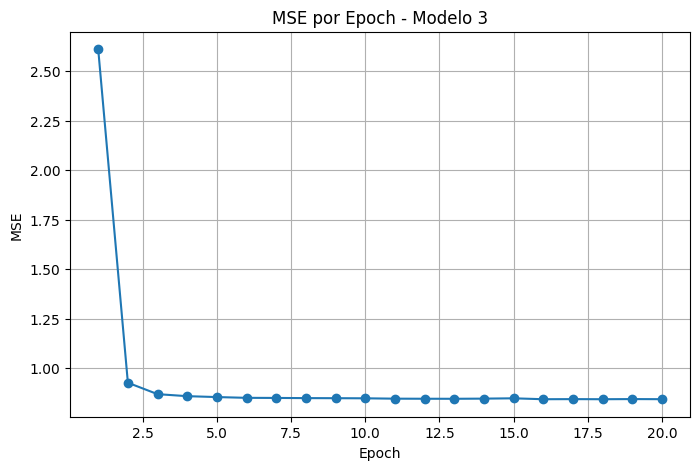

In [50]:
models = mse_epochs_df['Model'].unique()
for model in models:
    df_model = mse_epochs_df[mse_epochs_df['Model'] == model]

    plt.figure(figsize=(8, 5))  # individual size for each chart
    plt.plot(df_model['Epoch'], df_model['MSE'], marker='o')
    plt.title(f'MSE per Epoch - {model}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.grid(True)
    plt.show()


      Model  Epoch     AUC
0   Model 1      1  0.7307
1   Model 1      2  0.7794
2   Model 1      3  0.7876
3   Model 1      4  0.7896
4   Model 1      5  0.7914
5   Model 1      6  0.7923
6   Model 1      7  0.7932
7   Model 1      8  0.7940
8   Model 1      9  0.7939
9   Model 1     10  0.7955
10  Model 1     11  0.7968
11  Model 1     12  0.7989
12  Model 2      1  0.7191
13  Model 2      2  0.7814
14  Model 2      3  0.7873
15  Model 2      4  0.7902
16  Model 2      5  0.7910
17  Model 2      6  0.7932
18  Model 2      7  0.7933
19  Model 2      8  0.7947
20  Model 2      9  0.7950
21  Model 2     10  0.7960
22  Model 2     11  0.7975
23  Model 2     12  0.7989
24  Model 2     13  0.8006
25  Model 2     14  0.8024
26  Model 2     15  0.8043
27  Model 3      1  0.6851
28  Model 3      2  0.7796
29  Model 3      3  0.7896
30  Model 3      4  0.7928
31  Model 3      5  0.7941
32  Model 3      6  0.7950
33  Model 3      7  0.7956
34  Model 3      8  0.7963
35  Model 3      9  0.7966
3

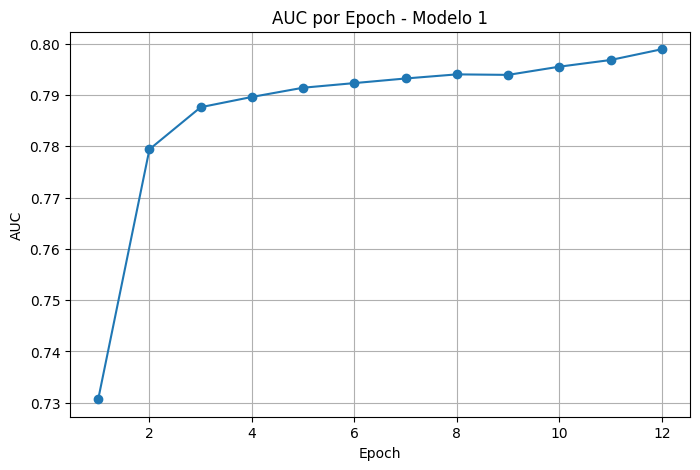

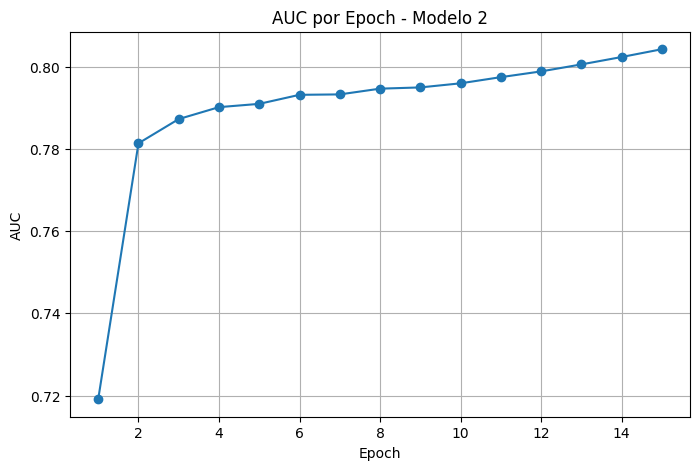

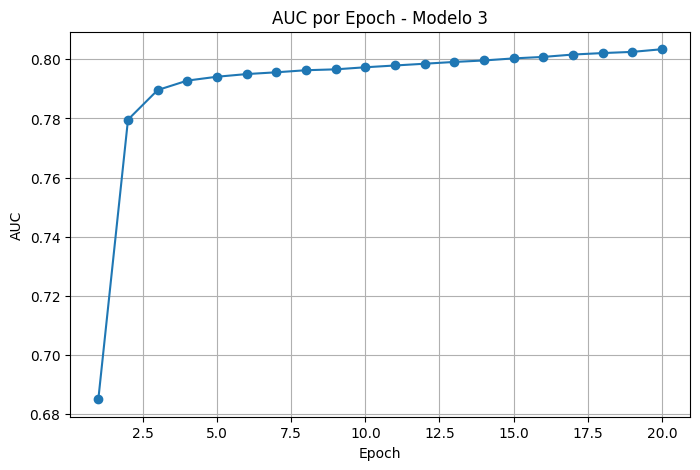

In [51]:
auc_modelo1 = [0.7307, 0.7794, 0.7876, 0.7896, 0.7914, 0.7923, 0.7932, 0.7940, 0.7939, 0.7955, 0.7968, 0.7989]
auc_modelo2 = [0.7191, 0.7814, 0.7873, 0.7902, 0.7910, 0.7932, 0.7933, 0.7947, 0.7950, 0.7960, 0.7975, 0.7989, 0.8006, 0.8024, 0.8043]
auc_modelo3 = [0.6851, 0.7796, 0.7896, 0.7928, 0.7941, 0.7950, 0.7956, 0.7963, 0.7966, 0.7973,
               0.7979, 0.7985, 0.7991, 0.7996, 0.8003, 0.8008, 0.8016, 0.8021, 0.8025, 0.8034]
data_auc = []
# Model 1
for epoch, auc in enumerate(auc_modelo1, start=1):
    data_auc.append({"Model": "Model 1", "Epoch": epoch, "AUC": auc})

# Model 2
for epoch, auc in enumerate(auc_modelo2, start=1):
    data_auc.append({"Model": "Model 2", "Epoch": epoch, "AUC": auc})

# Model 3
for epoch, auc in enumerate(auc_modelo3, start=1):
    data_auc.append({"Model": "Model 3", "Epoch": epoch, "AUC": auc})
auc_epochs_df = pd.DataFrame(data_auc)
print(auc_epochs_df)
modelos = auc_epochs_df['Model'].unique()

for model in models:
    df_modelo = auc_epochs_df[auc_epochs_df['Model'] == model]

    plt.figure(figsize=(8, 5))
    plt.plot(df_modelo['Epoch'], df_modelo['AUC'], marker='o')
    plt.title(f'AUC por Epoch - {model}')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.grid(True)
    plt.show()

Model 3 achieves the best MSE, indicating the lowest prediction error among the three.

El Model 2 tuvo el mejor AUC → es el que clasifica mejor.

## Hypothesis check

A simple validation is performed to see whether the engineered day-type context captures measurable behavioral differences in viewing patterns.

In [56]:
import pandas as pd
occupation_map = {
    0: 'Other/unspecified',
    1: 'Academic/Educator',
    2: 'Artist',
    3: 'Engineer',
    4: 'Executive/Manager',
    5: 'Student',
    6: 'Homemaker',
    7: 'Healthcare professional',
    8: 'Lawyer',
    9: 'Programmer',
    10: 'Technician',
    11: 'Writer',
    12: 'Salesperson',
    13: 'Scientist',
    14: 'College student',
    15: 'Administrator',
    16: 'Other profession',
    17: 'Unemployed',
    18: 'Services',
    19: 'Self-employed',
    20: 'Doctor'}
day_type_map = {
    0: 'Weekday',
    1: 'Weekend'}

occupation_genre = df_total.groupby(['occupation', 'genres']).size().reset_index(name='count')
occupation_genre_max = occupation_genre.loc[occupation_genre.groupby('occupation')['count'].idxmax()]

occupation_daytype = df_total.groupby(['occupation', 'day_type']).size().reset_index(name='count')
occupation_daytype_max = occupation_daytype.loc[occupation_daytype.groupby('occupation')['count'].idxmax()]

final_table = pd.merge(occupation_genre_max[['occupation', 'genres']],
                       occupation_daytype_max[['occupation', 'day_type']],
                       on='occupation')
final_table['occupation'] = final_table['occupation'].map(occupation_map)
final_table['day_type'] = final_table['day_type'].map(day_type_map)
print(final_table)

                  occupation  genres    diadesemana
0     Other/unspecified     167   Weekday
1         Academic/Educator     167   Weekday
2                    Artist     167  Weekend
3                  Engineer     167   Weekday
4          Executive/Manager     167   Weekday
5                 Student     167   Weekday
6                Homemaker     167   Weekday
7       Healthcare professional     167   Weekday
8                    Lawyer     120   Weekday
9                Programmer     167  Weekend
10                   Technician     167   Weekday
11                  Writer     167   Weekday
12                  Salesperson     120   Weekday
13                Scientist     167   Weekday
14  Student universitario     167   Weekday
15             Administrator     167   Weekday
16            Other profession     120   Weekday
17               Unemployed     167   Weekday
18                 Services     120   Weekday
19                  Self-employed     167   Weekday
20               

The most frequent genre code in the dataset is **167**. Most of its views occur on **weekdays**, with fewer on **weekends**, supporting the idea that day-type context can be informative.